<center><font size = "10"> Week 9 - Long-term plasticity <center>
<center><font size = "8"> Home work - Solutions<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 8 
<br>Group member1: Chiara Maria Matti
<br>Group member2: Elena Grazia Gado
<br>Group member3: Eliser Josan Romero
    
__IMPORTANT:__<font size = "3"> Exercises in <font color='red'>red</font> are mandatory assignements to be delivered by next Monday before 23:59.

In [2]:
import neuron, time
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
%matplotlib inline

# Recompile external files, load & initialize
!nrnivmodl
neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

/home/W9
Mod files: "./VecStim.mod" "./stdp_cc.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


# <font color= 'red'>Ex 1:</font>  Evolution of synaptic conductance in STDP
    
<font size='3'> Let's explore further the changes of synaptic conductance over time in STDP. Go back to tutorial 1 section 3 and set up everything you need to run it. Once you are ready, expand the plot to 3x2, adding the following in the last row:
   - plot the total excitatory synaptic conductance 𝑔𝐸(𝑡) 
   - plot each of the synaptic conductance changes $g_i$ (similar to the $P_i(t)$ plot)


<font size='3'> With the help of these plots, answer the following questions:
   1) In the above, even though all the presynaptic neurons have the same average firing rate, many of the synapses seem to have been weakened? Did you expect that?
   2) Total synaptic conductance is fluctuating over time. How do you expect 𝑔𝐸 to fluctuate if synapses did not show any STDP like behavior?
   3) Do synaptic weights ever reach a stationary state when synapses show STDP?
    
<font size='3'><font color= 'red'>[2 pts]</font>

In [3]:
# Some functions to help you

# Define parameters of the STDP process
def default_pars_STDP(**kwargs):
    pars = {}
    
    # typical neuron parameters
    pars['V_th'] = -55.     # spike threshold [mV]
    pars['V_reset'] = -75.  # reset potential [mV]
    pars['tau_m'] = 10.     # membrane time constant [ms]
    pars['V_init'] = -65.   # initial potential [mV]
    pars['V_L'] = -75.      # leak reversal potential [mV]
    pars['tref'] = 2.       # refractory time (ms)
    
    # STDP parameters
    pars['A_plus'] = 0.008                   # magnitude of LTP
    pars['A_minus'] = pars['A_plus'] * 1.10  # magnitude of LTD
    pars['tau_stdp'] = 20.                   # STDP time constant [ms]
    
    # simulation parameters
    pars['T'] = 400.  # Total duration of simulation [ms]
    pars['dt'] = .1   # Simulation time step [ms]
    
    # external parameters if any
    for k in kwargs:
        pars[k] = kwargs[k]

    pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]
    return pars

def Poisson_generator(pars, rate, n, myseed=False):
    """Generates poisson trains
    Args:
        pars            : parameter dictionary
        rate            : noise amplitute [Hz]
        n               : number of Poisson trains
        myseed          : random seed. int or boolean
    Returns:
        pre_spike_train : spike train matrix, ith row represents whether
                          there is a spike in ith spike train over time
                          (1 if spike, 0 otherwise)
    """
    
    # Retrieve simulation parameters
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    
    # set random seed
    if myseed:
        np.random.seed(seed=myseed)
    else:
        np.random.seed()

    # generate uniformly distributed random variables
    u_rand = np.random.rand(n, Lt)

    # generate Poisson train
    poisson_train = 1. * (u_rand < rate * (dt / 1000.))

    return poisson_train

def generate_P(pars, pre_spike_train_ex):
    """
    track of pre-synaptic spikes
    Args:
        pars               : parameter dictionary
        pre_spike_train_ex : binary spike train input from
                             presynaptic excitatory neuron
    Returns:
        P                  : LTP ratio
    """
    # Get parameters
    A_plus, tau_stdp = pars['A_plus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    # Initialize
    P = np.zeros(pre_spike_train_ex.shape)
    for it in range(Lt - 1):
        # Calculate the delta increment dP
        dP = -(dt / tau_stdp) * P[:, it] + A_plus * pre_spike_train_ex[:, it + 1]
        # Update P
        P[:, it + 1] = P[:, it] + dP
    return P

In [4]:
# Function for LIF neuron with STDP synapses

def run_LIF_cond_STDP(pars, pre_spike_train_ex):
    """
    conductance-based LIF dynamics

    Args:
        pars               : parameter dictionary
        pre_spike_train_ex : spike train input from presynaptic excitatory neuron

    Returns:
        rec_spikes         : spike times
        rec_v              : mebrane potential
        gE                 : postsynaptic excitatory conductance
    """

    # Retrieve parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m = pars['tau_m']
    V_init, V_L = pars['V_init'], pars['V_L']
    gE_bar, VE, tau_syn_E = pars['gE_bar'], pars['VE'], pars['tau_syn_E']
    gE_init = pars['gE_init']
    tref = pars['tref']
    A_minus, tau_stdp = pars['A_minus'], pars['tau_stdp']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size

    P = generate_P(pars, pre_spike_train_ex)

    # Initialize
    tr = 0.
    v = np.zeros(Lt)
    v[0] = V_init
    M = np.zeros(Lt)
    gE = np.zeros(Lt)
    gE_bar_update = np.zeros(pre_spike_train_ex.shape)
    gE_bar_update[:, 0] = gE_init  # note: gE_bar is the maximum value

    # simulation
    rec_spikes = []  # recording spike times
    for it in range(Lt - 1):
        if tr > 0:
            v[it] = V_reset
            tr = tr - 1
        elif v[it] >= V_th:   # reset voltage and record spike event
            rec_spikes.append(it)
            v[it] = V_reset
            M[it] = M[it] - A_minus
            gE_bar_update[:, it] = gE_bar_update[:, it] + P[:, it] * gE_bar
            id_temp = gE_bar_update[:, it] > gE_bar
            gE_bar_update[id_temp, it] = gE_bar
            tr = tref / dt

        # update the synaptic conductance
        M[it + 1] = M[it] - dt / tau_stdp * M[it]
        gE[it + 1] = gE[it] - (dt / tau_syn_E) * gE[it] + (gE_bar_update[:, it] * pre_spike_train_ex[:, it]).sum()
        gE_bar_update[:, it + 1] = gE_bar_update[:, it] + M[it]*pre_spike_train_ex[:, it]*gE_bar
        id_temp = gE_bar_update[:, it + 1] < 0
        gE_bar_update[id_temp, it + 1] = 0.

        # calculate the increment of the membrane potential
        dv = (-(v[it] - V_L) - gE[it + 1] * (v[it] - VE)) * (dt / tau_m)

        # update membrane potential
        v[it + 1] = v[it] + dv

    rec_spikes = np.array(rec_spikes) * dt

    return v, rec_spikes, gE, P, M, gE_bar_update

In [7]:
# Figures of the evolution of synaptic conductance
def my_raster_plot(range_t, spike_train, n):
    """Generates poisson trains

    Args:
        range_t     : time sequence
        spike_train : binary spike trains, with shape (N, Lt)
        n           : number of Poisson trains plot

    Returns:
        Raster_plot of the spike train
    """

    # Find the number of all the spike trains
    N = spike_train.shape[0]

    # n should be smaller than N:
    if n > N:
        print('The number n exceeds the size of spike trains')
        print('The number n is set to be the size of spike trains')
        n = N

    # Raster plot
    i = 0
    while i <= n:
        if spike_train[i, :].sum() > 0.:
            t_sp = range_t[spike_train[i, :] > 0.5]  # spike times
            plt.plot(t_sp, i * np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
        i += 1
    plt.xlim([range_t[0], range_t[-1]])
    plt.ylim([-0.5, n + 0.5])
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')

def make_plot():    
    # Run this cell to see the figures!
    plt.figure(figsize=(12, 5))
    plt.subplot(321)
    dt, range_t = pars['dt'], pars['range_t']
    if rec_spikes.size:
        sp_num = (rec_spikes / dt).astype(int) - 1
        v[sp_num] += 10   # add artificial spikes
    plt.plot(pars['range_t'], v, 'k')
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')

    plt.subplot(322)
    # Plot the sample presynaptic spike trains
    my_raster_plot(pars['range_t'], pre_spike_train_ex, 10)

    plt.subplot(323)
    plt.plot(pars['range_t'], M, 'k')
    plt.xlabel('Time (ms)')
    plt.ylabel('M')

    plt.subplot(324)
    for i in range(10):
        plt.plot(pars['range_t'], P[i, :])
    plt.xlabel('Time (ms)')
    plt.ylabel('P')

    
    plt.subplot(325)
    plt.plot(pars['range_t'], gE, 'k')
    plt.xlabel('Time (ms)')
    plt.ylabel('g_E')
    
    plt.subplot(326)
    for i in range(10):
        plt.plot(pars['range_t'], gE_bar_update[i, :])
    plt.xlabel('Time (ms)')
    plt.ylabel('g_i')

    plt.tight_layout()
    plt.show()
    

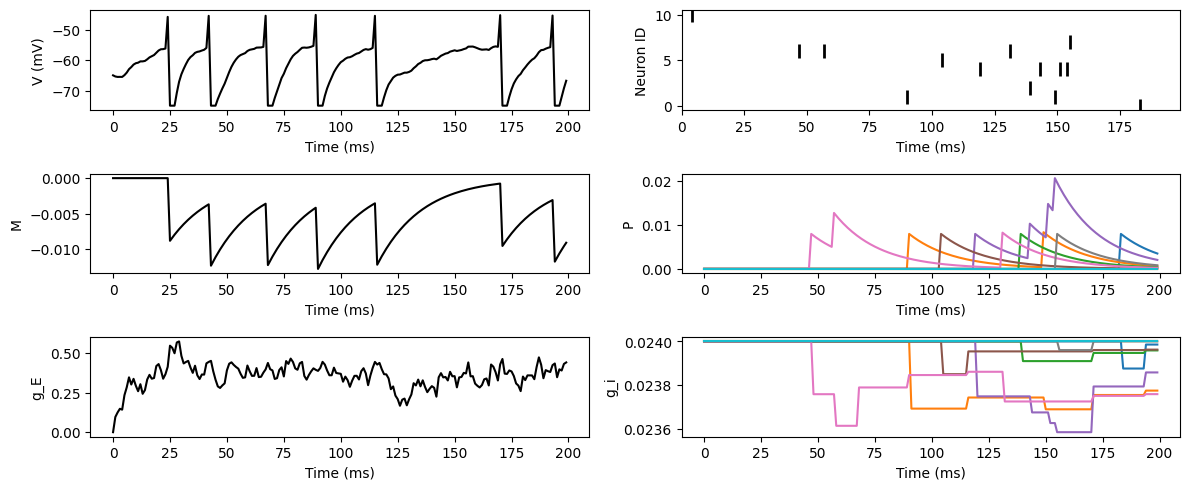

In [8]:
pars = default_pars_STDP(T=200., dt=1.)  # Simulation duration 200 ms
pars['gE_bar'] = 0.024                   # max synaptic conductance
pars['gE_init'] = 0.024                  # initial synaptic conductance
pars['VE'] = 0.                          # [mV] Synapse reversal potential
pars['tau_syn_E'] = 5.                   # [ms] EPSP time constant

# generate Poisson type spike trains
pre_spike_train_ex = Poisson_generator(pars, rate=10, n=300, myseed=2020)

# simulate the LIF neuron and record the synaptic conductance
v, rec_spikes, gE, P, M, gE_bar_update = run_LIF_cond_STDP(pars,pre_spike_train_ex)
make_plot()

1. Yes, first we note that there is a maximum value that the synaptic conductance can assume and that the weights were initialized with this exact value, therefore g_i can only decrease initially. In general, g_i can eather dicrease or increase depending on the relative timing of presynaptic and postsynaptic firing: if the presynaptic AP comes before the postsynaptic one, then g_i increases, whereas if the presynaptic AP arrives after the postsynaptic one, the opposite happens. Therefore, since the firing is modeled as a random process, we do expect some synapses to be weakened.
2. The total conductance would still vary based on the poststynaptic membrane properties (tau) similarly to the variations in Vm. 
3. 

# <font color='red'>Ex 2:</font> Evolution of synaptic weights and STDP conditions

<font size='3'> copy and use the widget at the end of tutorial 1 to explore how synaptic weights change over time and given different conditions:
   1) Increase the firing rate (i.e., 30 Hz) of presynaptic neurons, and investigate the effect on the dynamics of synaptic weight distribution
   2) halve the population size of presynaptic neurons, what do you observe? What happens if you double it?
   3) What happens if you double the EPSP time constant? How do you explain this?
   4) And if you decrease it to 4ms? What is the simple, smallest change you can make to reproduce the previous behavior? Can you find another, equivalent change that also does the same? Does this make sense with the previous answers?

<font color= 'red'>[2 pts]</font>

# <font color='red'>Ex 3:</font> Voltage-dependent plasticity model

The clopath et al. model can explain the dependence of not just timing but also frequency on plasticity.

Simulate the model as in tutorial 2 and vary both the spike timing and frequency of stimulation. 
For speed, use just one repetition of 5 spikes and an interstimulus interval of 400.
Use $\Delta t$ values -10, -7, -5, 5, 7, 10 ms and frequency values 2, 5, 10, 20, 40 Hz.
Plot the STDP curves for different frequencies on the same axis (allowing you to compare)

1. What is the effect of frequency on LTD and on LTP?
2. How does this effect result from the model?

<font color='red'> [2 pts]